1.77 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
288 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


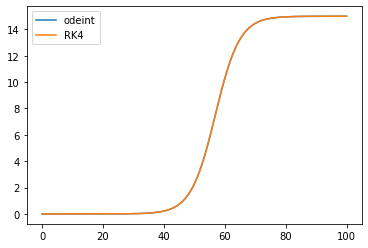

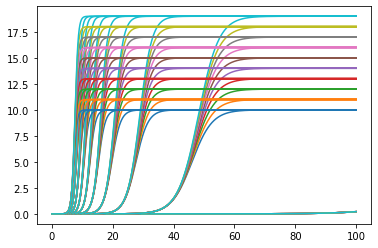

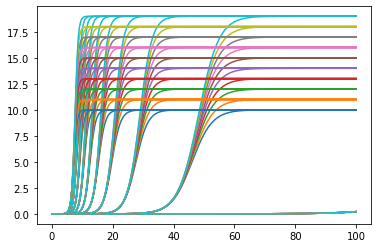

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


def rk4(func, y0, t, h, *args):
    dydt = np.zeros((len(t), len(y0)))
    dydt[0, :] = y0
    for i in range(1, len(t)):
        yi = dydt[i - 1, :]
        k1 = func(yi, t[i], *args) * h
        k2 = func(yi + 0.5 * k1, t[i] + 0.5 * h, *args) * h
        k3 = func(yi + 0.5 * k2, t[i] + 0.5 * h, *args) * h
        k4 = func(yi + k3, t[i] + h, *args) * h
        dydt[i, :] = yi + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
    return dydt

def logmodel(n, t, r, K):
    return r*n*(1-n/K)

r0 = 0.25
K0 = 15
maxt = 100
dt = 1./100
t = np.linspace(0,maxt,int(maxt/dt)+1)
N0 = 1e-5

mod_sol_odeint = odeint(logmodel, N0, t, (r0, K0))
mod_sol_rk4 = rk4(logmodel, np.array([N0]), t, dt, *(r0, K0))
plt.figure()
plt.plot(t, mod_sol_odeint, label='odeint')
plt.plot(t, mod_sol_rk4, label='RK4')
plt.legend()

%timeit odeint(logmodel, N0, t, (r0, K0))
%timeit rk4(logmodel, np.array([N0]), t, dt, *(r0, K0))

# =============================================
# Test of different parameters
# =============================================
import itertools as itt

r_values = np.arange(0.1,2,0.2)
K_values = np.arange(10, 20, 1)

def test(r_vals, k_val, fast_solver=True):
    exp_list = list(itt.product(r_vals, k_val))
    all_sol = []
    for exp in exp_list:
        if fast_solver:
            mod_sol = odeint(logmodel, N0, t, exp)
        else:
            mod_sol = rk4(logmodel, np.array([N0]), t, dt, *exp)
        all_sol.append(mod_sol)
    return all_sol

all_odeint = test(r_values, K_values, fast_solver=True)
all_rk4 = test(r_values, K_values, fast_solver=False)

plt.figure()
plt.plot(t, np.array(all_odeint).reshape(100,10001).T)

plt.figure()
plt.plot(t, np.array(all_rk4).reshape(100,10001).T)

#%timeit test(r_values, K_values, fast_solver=True)
#%timeit test(r_values, K_values, fast_solver=False)

# =============================================
# Test of different parameters in PARALLEL
# =============================================


In [2]:
import dask
from dask.distributed import Client
client = Client()

def test_parallel(r_vals, k_val, fast_solver=True):
    exp_list = list(itt.product(r_vals, k_val))
    all_sol = []
    for exp in exp_list:
        if fast_solver:
            mod_sol = dask.delayed(odeint)(logmodel, N0, t, exp)
        else:
            mod_sol = dask.delayed(rk4)(logmodel, np.array([N0]), t, dt, *exp)
        all_sol.append(mod_sol)
    return all_sol


all_odeint = test_parallel(r_values, K_values, fast_solver=True)
all_rk4 = test_parallel(r_values, K_values, fast_solver=False)

output = dask.compute(all_odeint)

In [4]:
all_odeint.visualize()

AttributeError: 'list' object has no attribute 'visualize'